In [1]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 10.8 MB/s eta 0:00:00


In [2]:
import pandas as pd
df = pd.read_csv("sejong1000QA.csv")

In [3]:
from sklearn.model_selection import train_test_split

# Train-test split
train_data, test_data = train_test_split(df, test_size=0.25)

In [4]:
# 변환 함수 정의
def format_data(row):
    formatted_text = f"<s>[Q] {row['Q']} [/Q] [label] {row['label']} [/label] {row['A']} </s>"
    return {"formatted_text": formatted_text}

In [5]:
import datasets

# 데이터셋 변환
formatted_train_dataset = train_data.apply(format_data, axis=1).tolist()
train_dataset = datasets.Dataset.from_pandas(pd.DataFrame(data=formatted_train_dataset))

formatted_test_dataset = test_data.apply(format_data, axis=1).tolist()
test_dataset = datasets.Dataset.from_pandas(pd.DataFrame(data=formatted_test_dataset))

In [6]:
train_dataset

Dataset({
    features: ['formatted_text'],
    num_rows: 756
})

In [7]:
test_dataset

Dataset({
    features: ['formatted_text'],
    num_rows: 253
})

In [8]:
!pip install -q accelerate==0.21.0 peft==0.4.0 bitsandbytes==0.40.2 transformers==4.31.0 trl==0.4.7

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.9/72.9 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.5/92.5 MB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 91.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.4/77.4 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 55.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 69.7 MB/s eta 0:00:00


In [9]:
import os
import torch
from datasets import load_dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    HfArgumentParser,
    TrainingArguments,
    pipeline,
    logging,
)
from peft import LoraConfig, PeftModel
from trl import SFTTrainer

In [10]:
# The model that you want to train from the Hugging Face hub
model_name = "NousResearch/Llama-2-7b-hf"

# The instruction dataset to use
dataset_name = "train_dataset"

# Fine-tuned model name
new_model = "silok"

################################################################################
# QLoRA parameters
################################################################################

# LoRA attention dimension
lora_r = 64

# Alpha parameter for LoRA scaling
lora_alpha = 16

# Dropout probability for LoRA layers
lora_dropout = 0.1

################################################################################
# bitsandbytes parameters
################################################################################

# Activate 4-bit precision base model loading
use_4bit = True

# Compute dtype for 4-bit base models
bnb_4bit_compute_dtype = "float16"

# Quantization type (fp4 or nf4)
bnb_4bit_quant_type = "nf4"

# Activate nested quantization for 4-bit base models (double quantization)
use_nested_quant = False

################################################################################
# TrainingArguments parameters
################################################################################

# Output directory where the model predictions and checkpoints will be stored
output_dir = "./results"

# Number of training epochs
num_train_epochs = 1

# Enable fp16/bf16 training (set bf16 to True with an A100)
fp16 = False
bf16 = False

# Batch size per GPU for training
per_device_train_batch_size = 4

# Batch size per GPU for evaluation
per_device_eval_batch_size = 4

# Number of update steps to accumulate the gradients for
gradient_accumulation_steps = 1

# Enable gradient checkpointing
gradient_checkpointing = True

# Maximum gradient normal (gradient clipping)
max_grad_norm = 0.3

# Initial learning rate (AdamW optimizer)
learning_rate = 2e-4

# Weight decay to apply to all layers except bias/LayerNorm weights
weight_decay = 0.001

# Optimizer to use
optim = "paged_adamw_32bit"

# Learning rate schedule
lr_scheduler_type = "cosine"

# Number of training steps (overrides num_train_epochs)
max_steps = -1

# Ratio of steps for a linear warmup (from 0 to learning rate)
warmup_ratio = 0.03

# Group sequences into batches with same length
# Saves memory and speeds up training considerably
group_by_length = True

# Save checkpoint every X updates steps
save_steps = 0

# Log every X updates steps
logging_steps = 1

eval_steps = 1

################################################################################
# SFT parameters
################################################################################

# Maximum sequence length to use
max_seq_length = None

# Pack multiple short examples in the same input sequence to increase efficiency
packing = False

# Load the entire model on the GPU 0
device_map = {"": 0}

In [11]:
# Load dataset (you can process it here)
#dataset = load_dataset(dataset_name, split="train")

# Load tokenizer and model with QLoRA configuration
compute_dtype = getattr(torch, bnb_4bit_compute_dtype)

bnb_config = BitsAndBytesConfig(
    load_in_4bit=use_4bit,
    bnb_4bit_quant_type=bnb_4bit_quant_type,
    bnb_4bit_compute_dtype=compute_dtype,
    bnb_4bit_use_double_quant=use_nested_quant,
)

# Check GPU compatibility with bfloat16
if compute_dtype == torch.float16 and use_4bit:
    major, _ = torch.cuda.get_device_capability()
    if major >= 8:
        print("=" * 80)
        print("Your GPU supports bfloat16: accelerate training with bf16=True")
        print("=" * 80)

# Load base model
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map=device_map
)
model.config.use_cache = False
model.config.pretraining_tp = 1

# Load LLaMA tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right" # Fix weird overflow issue with fp16 training

# Load LoRA configuration
peft_config = LoraConfig(
    lora_alpha=lora_alpha,
    lora_dropout=lora_dropout,
    r=lora_r,
    bias="none",
    task_type="CAUSAL_LM",
)

# Set training parameters
training_arguments = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=num_train_epochs,
    per_device_train_batch_size=per_device_train_batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    optim=optim,
    save_steps=save_steps,
    logging_steps=logging_steps,
    learning_rate=learning_rate,
    weight_decay=weight_decay,
    fp16=fp16,
    bf16=bf16,
    max_grad_norm=max_grad_norm,
    max_steps=max_steps,
    warmup_ratio=warmup_ratio,
    group_by_length=group_by_length,
    lr_scheduler_type=lr_scheduler_type,
    report_to="tensorboard"
)

# Set supervised fine-tuning parameters
trainer = SFTTrainer(
    model=model,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    peft_config=peft_config,
    dataset_text_field="formatted_text",
    max_seq_length=max_seq_length,
    tokenizer=tokenizer,
    args=training_arguments,
    packing=packing,
)

# Train model
trainer.train()

# Save trained model
trainer.model.save_pretrained(new_model)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/other.py:102: FutureWarning: prepare_model_for_int8_training is deprecated and will be removed in a future version. Use prepare_model_for_kbit_training instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:159: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(


Map:   0%|          | 0/756 [00:00<?, ? examples/s]

Map:   0%|          | 0/253 [00:00<?, ? examples/s]

You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss
1,1.188300
2,1.113100
3,1.359200
4,1.171700
5,1.173600
6,1.231100
7,0.983800
8,0.906200
9,1.007900
10,1.235600


KeyboardInterrupt: ignored

In [12]:
# Load dataset (you can process it here)
#dataset = load_dataset(dataset_name, split="train")

# Load tokenizer and model with QLoRA configuration
compute_dtype = getattr(torch, bnb_4bit_compute_dtype)

bnb_config = BitsAndBytesConfig(
    load_in_4bit=use_4bit,
    bnb_4bit_quant_type=bnb_4bit_quant_type,
    bnb_4bit_compute_dtype=compute_dtype,
    bnb_4bit_use_double_quant=use_nested_quant,
)

# Check GPU compatibility with bfloat16
if compute_dtype == torch.float16 and use_4bit:
    major, _ = torch.cuda.get_device_capability()
    if major >= 8:
        print("=" * 80)
        print("Your GPU supports bfloat16: accelerate training with bf16=True")
        print("=" * 80)

# Load base model
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map=device_map
)
model.config.use_cache = False
model.config.pretraining_tp = 1

# Load LLaMA tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right" # Fix weird overflow issue with fp16 training

# Load LoRA configuration
peft_config = LoraConfig(
    lora_alpha=lora_alpha,
    lora_dropout=lora_dropout,
    r=lora_r,
    bias="none",
    task_type="CAUSAL_LM",
)

# Set training parameters
training_arguments = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=num_train_epochs,
    per_device_train_batch_size=per_device_train_batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    optim=optim,
    save_steps=save_steps,
    logging_steps=logging_steps,
    learning_rate=learning_rate,
    weight_decay=weight_decay,
    fp16=fp16,
    bf16=bf16,
    max_grad_norm=max_grad_norm,
    max_steps=max_steps,
    warmup_ratio=warmup_ratio,
    group_by_length=group_by_length,
    lr_scheduler_type=lr_scheduler_type,
    evaluation_strategy="steps",  # Evaluate at specific steps
    eval_steps=eval_steps,  # Set the evaluation step interval
    report_to="tensorboard"
)

# Set supervised fine-tuning parameters
trainer = SFTTrainer(
    model=model,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    peft_config=peft_config,
    dataset_text_field="formatted_text",
    max_seq_length=max_seq_length,
    tokenizer=tokenizer,
    args=training_arguments,
    packing=packing,
)

# Train model
trainer.train()

# Save trained model
trainer.model.save_pretrained(new_model)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Map:   0%|          | 0/756 [00:00<?, ? examples/s]

Map:   0%|          | 0/253 [00:00<?, ? examples/s]

You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss
1,1.188300,1.464255
2,1.113100,1.461316
3,1.359200,1.455222
4,1.171700,1.446687
5,1.173800,1.432804
6,1.231100,1.411973
7,0.983900,1.381430
8,0.906200,1.345453
9,1.007600,1.307851
10,1.235500,1.268146


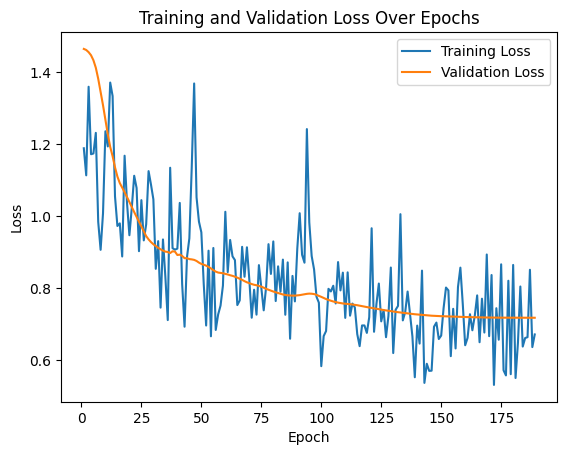

In [13]:
import matplotlib.pyplot as plt

# Get the training history
training_history = trainer.state.log_history

# Extract training loss for each epoch
train_losses = [item['loss'] for item in training_history if 'loss' in item]

# Extract validation loss for each epoch
validation_losses = [item['eval_loss'] for item in training_history if 'eval_loss' in item]

# Plot the training and validation loss graph
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(validation_losses) + 1), validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()


In [ ]:
# Ignore warnings
logging.set_verbosity(logging.CRITICAL)

# Run text generation pipeline with our next model
prompt = "업적은?"
label = 0
pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_length=200)
result = pipe(f"<s>[Q] {prompt} [/Q] [label] {label} [/label]")
print(result[0]['generated_text'])

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1270: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation )
  warnings.warn(


In [ ]:
# Ignore warnings
logging.set_verbosity(logging.CRITICAL)

# Run text generation pipeline with our next model
prompt = "6조 직계제가 무엇인가요?"
label = 1
pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_length=200)
result = pipe(f"<s>[Q] {prompt} [/Q] [label] {label} [/label]")
print(result[0]['generated_text'])

<s>[Q] 6조 직계제가 무엇인가요? [/Q] [label] 1 [/label] 6조 직계제는 왕이 통치하는 제도였다. 왕이 직접 정치를 행하고 국정을 처리하는 것이 특징이다. 이는 왕의 통치력과 권력을 강화하고 국가의 안정과 통치 체제를 확립하기 위한 목적이 있었다. 이


In [ ]:
# Ignore warnings
logging.set_verbosity(logging.CRITICAL)

# Run text generation pipeline with our next model
prompt = "해시계에 대해 설명해주세요"
label = 4
pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_length=200)
result = pipe(f"<s>[Q] {prompt} [/Q] [label] {label} [/label]")
print(result[0]['generated_text'])

<s>[Q] 해시계에 대해 설명해주세요 [/Q] [label] 4 [/label] 해시계는 시간을 측정하는 데 사용되는 기계적인 장치로, 시간을 측정하는 데 사용되는 데 사용된다. 해시계는 시간을 측정하는 데 사용되는 데 사용되는 데 사용된다. 해시계는 시간을 측정하는 데 사용


In [ ]:
# Ignore warnings
logging.set_verbosity(logging.CRITICAL)

# Run text generation pipeline with our next model
prompt = "법전 정비에 대해 알려줘"
label = 5
pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_length=200)
result = pipe(f"<s>[Q] {prompt} [/Q] [label] {label} [/label]")
print(result[0]['generated_text'])

<s>[Q] 법전 정비에 대해 알려줘 [/Q] [label] 5 [/label] 짐은 법전 정비를 통해 국가의 법치와 사회 질서를 강화하고자 했다. 짐은 법전 정비를 위해 법학자들을 초청하여 법전을 완성하였다. 이 법전은 조선시대 법률의 기반이 되었으며, 조선 시대 법률의 


In [ ]:
# Ignore warnings
logging.set_verbosity(logging.CRITICAL)

# Run text generation pipeline with our next model
prompt = "세종시기가 가지는 역사적 의의는?"
label = 4
pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_length=200)
result = pipe(f"<s>[Q] {prompt} [/Q] [label] {label} [/label]")
print(result[0]['generated_text'])

<s>[Q] 세종시기가 가지는 역사적 의의는? [/Q] [label] 4 [/label] 짐의 통치시절은 조선의 역사적 중심이 되었고, 조선의 문화와 정치적 통치 방식을 형성하는 데 큰 역할을 했다. 짐의 통치시절은 조선의 발전과 번영을 이루는 데 큰 역할을 했다. 짐의


In [ ]:
# Empty VRAM
del model
del pipe
del trainer
import gc
gc.collect()
gc.collect()

19965

In [ ]:
# Reload model in FP16 and merge it with LoRA weights
base_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    low_cpu_mem_usage=True,
    return_dict=True,
    torch_dtype=torch.float16,
    device_map=device_map,
)
model = PeftModel.from_pretrained(base_model, new_model)
model = model.merge_and_unload()

# Reload tokenizer to save it
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

OutOfMemoryError: ignored

In [ ]:
!huggingface-cli login

model.push_to_hub(new_model, use_temp_dir=False)
tokenizer.push_to_hub(new_model, use_temp_dir=False)